In [34]:


DATA_DIR = r"F:\MultiDimensionalAD\data\real_time_MKPL"

import os
import glob
import pandas as pd
import os
import glob
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


csv_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))

dfs = []
for f in csv_files:
    df = pd.read_csv(f)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

print("Total rows:", len(df_all))

# ---------------- CONFIG ----------------
SEQ_LEN = 30
BATCH_SIZE = 64
EPOCHS = 50
PCA_COMPONENTS = 3
LATENT_DIM = 32
LR = 1e-3

SAVE_DIR = "checkpoints"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SENSOR_FILTERS = ['-PT-', '-TT-', '-TI-', '-PI-']

os.makedirs(SAVE_DIR, exist_ok=True)



Total rows: 272238


In [35]:
# drop time columns
df_all = df_all.drop(columns=["Seconds", "Timestamp_IST"], errors="ignore")
df_all = df_all.filter(regex='|'.join(SENSOR_FILTERS))

# keep numeric only
df_all = df_all.select_dtypes(include=[np.number])

# drop NaNs
df_all = df_all.dropna()

X = df_all.values.astype(np.float32)


In [36]:
print(df_all.columns)

Index(['GU-PI-1901', 'GU-PI-1915', 'JK-PI-1501', 'JK-PI-1503', 'JW-PI-1601',
       'JW-PI-1603', 'I2-PI-2205', 'MA-PI-1307', 'MA-PI-1359', 'MG-PI-1701',
       ...
       'S32-TI-1432A', 'S32-TI-1432B', 'S33-TI-1433A', 'S33-TI-1433B',
       'S34-TI-1434A', 'S34-TI-1434B', 'S35-TI-1435A', 'S35-TI-1435B',
       'WA-TI-1201', 'WA-TI-1205'],
      dtype='object', length=133)


In [37]:
X = df_all.values.astype(np.float32)



In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=PCA_COMPONENTS)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.3650283  0.1735033  0.14611241]


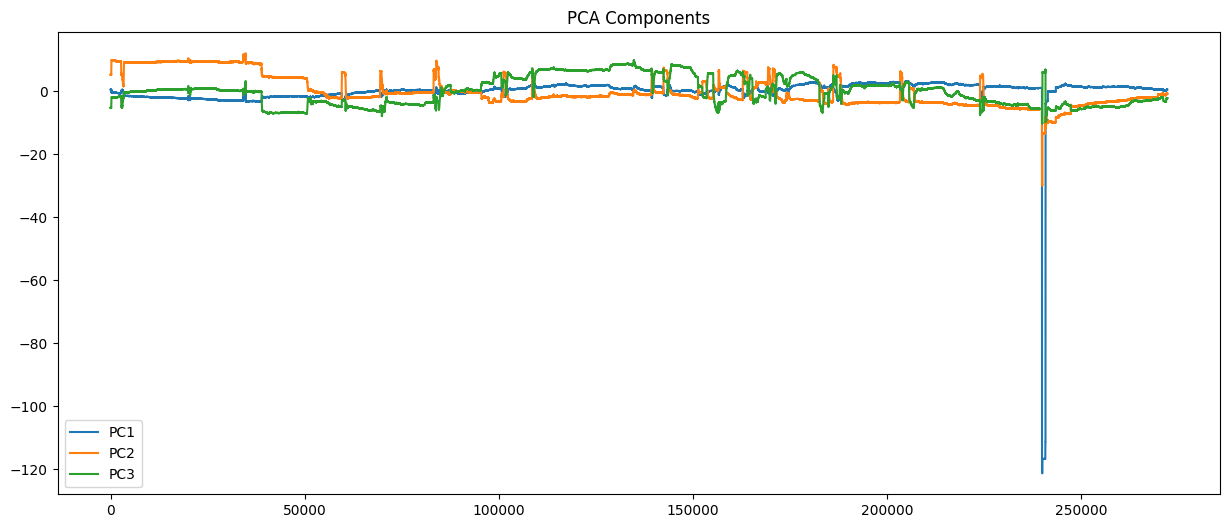

In [43]:
# make plot for a sensor
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))    
plt.plot(X_pca[:, 0], label="PC1")
plt.plot(X_pca[:, 1], label="PC2")
plt.plot(X_pca[:, 2], label="PC3")
plt.legend()
plt.title("PCA Components")
plt.show()

In [45]:
def make_sequences(data, seq_len):
    return np.array([
        data[i:i + seq_len]
        for i in range(len(data) - seq_len)
    ])

X_seq = make_sequences(X_pca, SEQ_LEN)
X_seq = torch.tensor(X_seq, dtype=torch.float32)

print("Sequences:", X_seq.shape)


Sequences: torch.Size([272208, 30, 3])


In [46]:
dataset = TensorDataset(X_seq)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)


In [ ]:
class CNNLSTMAutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()

        # -------- Encoder (Temporal CNN) --------
        self.encoder_cnn = nn.Sequential(
            nn.Conv1d(input_dim, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # -------- LSTM Bottleneck --------
        self.encoder_lstm = nn.LSTM(
            input_size=64,
            hidden_size=latent_dim,
            num_layers=2,
            batch_first=True
        )

        # -------- Decoder LSTM --------
        self.decoder_lstm = nn.LSTM(
            input_size=latent_dim,
            hidden_size=64,
            num_layers=2,
            batch_first=True
        )

        # -------- Decoder CNN --------
        self.decoder_cnn = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, input_dim, kernel_size=3, padding=1)
        )

    # def forward(self, x):
    #     # x: (B, T, C)

    #     # CNN expects (B, C, T)
    #     x = x.permute(0, 2, 1)

    #     z = self.encoder_cnn(x)
    #     z = z.permute(0, 2, 1)  # (B, T, 64)

    #     _, (h, _) = self.encoder_lstm(z)

    #     # repeat latent across time
    #     h = h[-1].unsqueeze(1).repeat(1, z.size(1), 1)

    #     out, _ = self.decoder_lstm(h)

    #     out = out.permute(0, 2, 1)
    #     out = self.decoder_cnn(out)
    #     out = out.permute(0, 2, 1)

    #     return out
    def forward(self, x):
        # x: (B, T, C)
        x = x.permute(0, 2, 1)          # (B, C, T)

        z = self.encoder_cnn(x)
        z = z.permute(0, 2, 1)          # (B, T, 64)

        enc_out, _ = self.encoder_lstm(z)     # (B, T, latent)
        dec_out, _ = self.decoder_lstm(enc_out)  # (B, T, 64)

        out = dec_out.permute(0, 2, 1)
        out = self.decoder_cnn(out)
        out = out.permute(0, 2, 1)

        return out



In [50]:
model = CNNLSTMAutoEncoder(PCA_COMPONENTS, LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


for epoch in range(1, EPOCHS + 1):
    model.train()
    losses = []

    for (batch,) in loader:
        batch = batch.to(DEVICE)

        recon = model(batch)
        loss = criterion(recon, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    mean_loss = float(np.mean(losses))
    print(f"Epoch {epoch} | loss {mean_loss:.6f}")

    torch.save(
        {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "scaler": scaler,
            "pca": pca,
            "seq_len": SEQ_LEN
        },
        os.path.join(SAVE_DIR, f"epoch_{epoch}.pt")
    )


Epoch 1 | loss 2.805295
Epoch 2 | loss 1.527657
Epoch 3 | loss 0.562902
Epoch 4 | loss 0.390106
Epoch 5 | loss 0.316415
Epoch 6 | loss 0.391584
Epoch 7 | loss 0.393045
Epoch 8 | loss 0.286705
Epoch 9 | loss 0.319758
Epoch 10 | loss 0.307850
Epoch 11 | loss 0.245801
Epoch 12 | loss 0.375956
Epoch 13 | loss 0.258569
Epoch 14 | loss 0.243131
Epoch 15 | loss 0.253015
Epoch 16 | loss 0.237222
Epoch 17 | loss 0.209662
Epoch 18 | loss 0.192149
Epoch 19 | loss 0.170401
Epoch 20 | loss 0.206570
Epoch 21 | loss 0.178328
Epoch 22 | loss 0.206268
Epoch 23 | loss 0.171442
Epoch 24 | loss 0.189948
Epoch 25 | loss 0.150297
Epoch 26 | loss 0.161506
Epoch 27 | loss 0.136324
Epoch 28 | loss 0.158191
Epoch 29 | loss 0.183246


KeyboardInterrupt: 

In [82]:
import matplotlib.pyplot as plt

def plot_anomalies(csv_path, checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)

    scaler = ckpt["scaler"]
    pca = ckpt["pca"]
    seq_len = ckpt["seq_len"]

    model = CNNLSTMAutoEncoder(PCA_COMPONENTS, LATENT_DIM).to(DEVICE)
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    df = pd.read_csv(csv_path)
    df = df.drop(columns=["Seconds", "Timestamp_IST"], errors="ignore")
    df = df.filter(regex='|'.join(SENSOR_FILTERS))
    df = df.select_dtypes(include=[np.number])
    df = df.dropna()

    X = scaler.transform(df.values.astype(np.float32))
    X_pca = PCA(n_components=PCA_COMPONENTS).fit_transform(X)

    X_seq = make_sequences(X_pca, seq_len)
    X_seq = torch.tensor(X_seq, dtype=torch.float32).to(DEVICE)

    with torch.no_grad():
        recon = model(X_seq)
        scores = torch.mean((recon - X_seq) ** 2, dim=(1, 2)).cpu().numpy()

    threshold = np.percentile(scores, 99.5)
    anomaly_idx = np.where(scores > threshold)[0]

    t = np.arange(len(X_pca))
    score_t = np.arange(len(scores)) + seq_len

    plt.figure(figsize=(16, 6))
    

    # plot PCA signal
    plt.plot(t, X_pca[:, 0], label="PCA component 0", linewidth=1)
    plt.plot(t, X_pca[:,1])
    plt.plot(t, X_pca[:,2])

    # mark anomalies
    plt.scatter(
        score_t[anomaly_idx],
        X_pca[score_t[anomaly_idx], 0],
        color="red",
        s=15,
        label="Anomaly"
    )
    plt.scatter(
        score_t[anomaly_idx],
        X_pca[score_t[anomaly_idx], 1],
        color="red",
        s=15,
        label="Anomaly"
    )
    plt.scatter(
        score_t[anomaly_idx],
        X_pca[score_t[anomaly_idx], 2],
        color="red",
        s=15,
        label="Anomaly"
    )

    plt.title("Time Series with Detected Anomalies")
    plt.xlabel("Time index")
    plt.ylabel("PCA value")
    plt.legend()
    plt.tight_layout()
    plt.show()


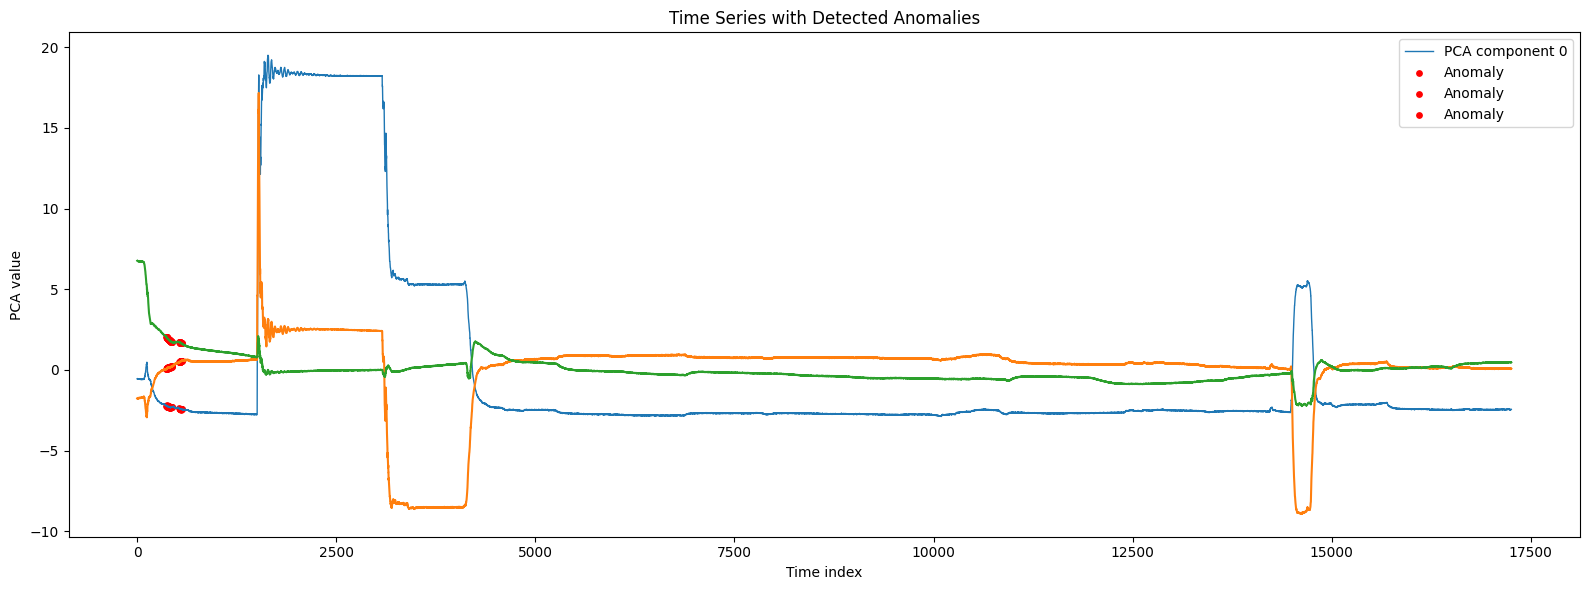

In [83]:
plot_anomalies(r"F:\MultiDimensionalAD\data\202505161524GMT+5x30.h24.csv", "checkpoints/epoch_25.pt")


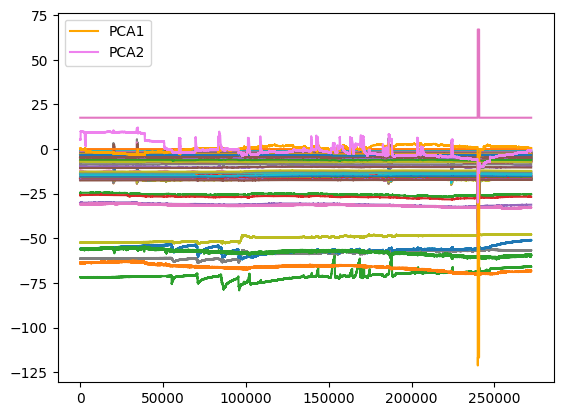

In [84]:
# using anomlay indcies plot these on unsclaed sensor 
scaled_x_plus = scaler.transform(X_scaled)
for sensor in scaled_x_plus.T:
    plt.plot(sensor)
    
plt.plot(X_pca[:, 0], label = 'PCA1', color='orange')
plt.plot(X_pca[:, 1], label = 'PCA2', color='violet')

plt.legend()
plt.show()